In [179]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt # type: ignore
import seaborn as sns # type: ignore
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import silhouette_score
import warnings
from scipy import stats


df = pd.read_parquet("Crime_Data.parquet")
original_rows = len(df)
df.head()


,DR_NO,Date Rptd,DATE OCC,TIME OCC,AREA,AREA NAME,Rpt Dist No,Part 1-2,Crm Cd,Crm Cd Desc,...,Status,Status Desc,Crm Cd 1,LOCATION,LAT,LON,occ_year,occ_month,occ_date,occ_day
0,211507896,2021-04-11,2020-11-07,08:45:00,15,N Hollywood,1502,2,354,THEFT OF IDENTITY,...,IC,Invest Cont,354.0,7800 BEEMAN AV,34.2124,-118.4092,2020,Nov,7,Sat
1,201516622,2020-10-21,2020-10-18,18:45:00,15,N Hollywood,1521,1,230,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",...,IC,Invest Cont,230.0,ATOLL AV,34.1993,-118.4203,2020,Oct,18,Sun
2,240913563,2024-12-10,2020-10-30,12:40:00,9,Van Nuys,933,2,354,THEFT OF IDENTITY,...,IC,Invest Cont,354.0,14600 SYLVAN ST,34.1847,-118.4509,2020,Oct,30,Fri
3,210704711,2020-12-24,2020-12-24,13:10:00,7,Wilshire,782,1,331,THEFT FROM MOTOR VEHICLE - GRAND ($950.01 AND ...,...,IC,Invest Cont,331.0,6000 COMEY AV,34.0339,-118.3747,2020,Dec,24,Thu
4,201418201,2020-10-03,2020-09-29,18:30:00,14,Pacific,1454,1,420,THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER),...,IC,Invest Cont,420.0,4700 LA VILLA MARINA,33.9813,-118.4350,2020,Sep,29,Tue


### STEP 2: IDENTIFY DATA QUALITY ISSUES


In [180]:
missing_values = df.isnull().sum()
missing_percent = (missing_values / len(df)) * 100

quality_df = pd.DataFrame({
    'Column': missing_values.index,
    'Missing_Count': missing_values.values,
    'Missing_Percentage': missing_percent.values
})

# Only show columns with missing data
quality_df = quality_df[quality_df['Missing_Count'] > 0].sort_values('Missing_Percentage', ascending=False)
print(quality_df.to_string())


Empty DataFrame
Columns: [Column, Missing_Count, Missing_Percentage]
Index: []


#### 2.2: Check for invalid values in specific columns


In [181]:
print(f"Age range in data: {df['Vict Age'].min()} to {df['Vict Age'].max()}")
print(f"How many ages are negative? {(df['Vict Age'] < 0).sum()}")
print(f"How many ages are over 120? {(df['Vict Age'] > 100).sum()}")
print(f"How many ages are 0? {(df['Vict Age'] == 0).sum()}")


Age range in data: -4 to 120
How many ages are negative? 137
How many ages are over 120? 1
How many ages are 0? 269222


In [182]:
bad_ages = df[df['Vict Age'] > 120][['Vict Age', 'Crm Cd Desc']].head()
print(f"\nExamples of invalid ages:\n{bad_ages}")


Examples of invalid ages:
Empty DataFrame
Columns: [Vict Age, Crm Cd Desc]
Index: []


#### 2.3: Check for bad date values


In [183]:
print(f"Date OCC data type: {df['DATE OCC'].dtype}")
print(f"Sample date_occ values:\n{df['DATE OCC'].head()}")
print(f"Sample date_reported values:\n{df['Date Rptd'].head()}")

Date OCC data type: datetime64[ns]
Sample date_occ values:
0   2020-11-07
1   2020-10-18
2   2020-10-30
3   2020-12-24
4   2020-09-29
Name: DATE OCC, dtype: datetime64[ns]
Sample date_reported values:
0   2021-04-11
1   2020-10-21
2   2024-12-10
3   2020-12-24
4   2020-10-03
Name: Date Rptd, dtype: datetime64[ns]


##### 2.4: Check for bad location data


In [184]:
print(f"Latitude range: {df['LAT'].min()} to {df['LAT'].max()}")
print(f"Longitude range: {df['LON'].min()} to {df['LON'].max()}")
print(f"How many records have (0,0) coordinates? {((df['LAT'] == 0) & (df['LON'] == 0)).sum()}")
print(f"How many records have null coordinates? {(df['LAT'].isnull().sum() + df['LON'].isnull().sum())}")

Latitude range: 0.0 to 34.3343
Longitude range: -118.6676 to 0.0
How many records have (0,0) coordinates? 2240
How many records have null coordinates? 0


#### 2.5: Check for duplicates


In [185]:
duplicates = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")

Number of duplicate rows: 0


### STEP 3: CLEAN THE DATA


#### 3.1: Rename columns to consistent snake_case format


In [186]:
df = df.rename(columns={
    'Date Rptd': 'date_reported',
    'DATE OCC': 'date_occ',
    'TIME OCC': 'time_occ',
    'AREA': 'area',
    'AREA NAME': 'area_name',
    'Rpt Dist No': 'rpt_dist_no',
    'Part 1-2': 'part_1_2',
    'Vict Age': 'vict_age',
    'Vict Sex': 'vict_sex',
    'Vict Descent': 'vict_descent',
    'Premis Cd': 'premis_cd',
    'Premis Desc': 'premis_desc',
    'Weapon Used Cd': 'weapon_used_cd',
    'Weapon Desc': 'weapon_desc',
    'Crm Cd': 'crm_cd',
    'Crm Cd Desc': 'crm_cd_desc',
    'Status Desc': 'status_desc'
})
print("✓Columns renamed successfully")
print(df.columns)

✓Columns renamed successfully
Index(['DR_NO', 'date_reported', 'date_occ', 'time_occ', 'area', 'area_name',
       'rpt_dist_no', 'part_1_2', 'crm_cd', 'crm_cd_desc', 'Mocodes',
       'vict_age', 'vict_sex', 'vict_descent', 'premis_cd', 'premis_desc',
       'weapon_used_cd', 'weapon_desc', 'Status', 'status_desc', 'Crm Cd 1',
       'LOCATION', 'LAT', 'LON', 'occ_year', 'occ_month', 'occ_date',
       'occ_day'],
      dtype='object')


#### 3.2: Convert date columns to datetime format


In [187]:
df['date_occ'] = pd.to_datetime(df['date_occ'], format='%m/%d/%Y', errors='coerce')
df['date_reported'] = pd.to_datetime(df['date_reported'], format='%m/%d/%Y', errors='coerce')

# Extract year, month, day from date_occ
df['occ_year'] = df['date_occ'].dt.year
df['occ_month'] = df['date_occ'].dt.month
df['occ_day'] = df['date_occ'].dt.day
df['occ_hour'] = df['time_occ'].apply(lambda t: t.hour if pd.notnull(t) else pd.NA).astype('Int64')
 # Extract hour from HHMM format
print("✓ Year, month, day and hour extracted from dates")

print(df[['time_occ','occ_hour']].head())


✓ Year, month, day and hour extracted from dates
   time_occ  occ_hour
0  08:45:00         8
1  18:45:00        18
2  12:40:00        12
3  13:10:00        13
4  18:30:00        18


#### 3.3: Clean invalid age values


In [188]:
before_age_clean = len(df)
# Remove records where age is negative, zero, or over 100
df = df[(df['vict_age'] > 0) & (df['vict_age'] <= 120)]

after_age_clean = len(df)
rows_removed_age = before_age_clean - after_age_clean
print(f"Removed {rows_removed_age} records with invalid ages")
print(f"Remaining rows: {after_age_clean}")

Removed 269359 records with invalid ages
Remaining rows: 735632


#### 3.4: Remove records with missing location data


In [189]:
before_location_clean = len(df)
# Remove records with zero coordinates AND missing LAT/LON

df = df[~((df['LAT'] == 0) & (df['LON'] == 0))]

after_location_clean = len(df)
rows_removed_location = before_location_clean - after_location_clean
print(f"Removed {rows_removed_location} records with (0,0) coordinates")
print(f"Remaining rows: {after_location_clean}")


Removed 1692 records with (0,0) coordinates
Remaining rows: 733940


#### 3.5: Remove duplicate records


In [190]:
before_dup_clean = len(df)

df = df.drop_duplicates()

after_dup_clean = len(df)
rows_removed_dup = before_dup_clean - after_dup_clean
print(f"Removed {rows_removed_dup} duplicate records")
print(f"Remaining rows: {after_dup_clean}")

Removed 0 duplicate records
Remaining rows: 733940


#### 3.6: Handle records with invalid years


In [191]:
before_year_clean = len(df)

# Keep only records from 2020-2025
df = df[(df['occ_year'] >= 2020) & (df['occ_year'] <= 2025)]

after_year_clean = len(df)
rows_removed_year = before_year_clean - after_year_clean
print(f"Removed {rows_removed_year} records with invalid years (not 2020-2025)")
print(f"Remaining rows: {after_year_clean}")

Removed 0 records with invalid years (not 2020-2025)
Remaining rows: 733940


### STEP 4: VERIFY CLEANING RESULTS


In [192]:
print(f"\n--- CLEANING SUMMARY ---")
total_removed = original_rows - len(df)
print(f"Original rows: {original_rows:,}")
print(f"Final rows: {len(df):,}")
print(f"Total rows removed: {total_removed:,} ({(total_removed/original_rows)*100:.2f}%)")


--- CLEANING SUMMARY ---
Original rows: 1,004,991
Final rows: 733,940
Total rows removed: 271,051 (26.97%)


## Part-2 : Data Profiling- DISCOVERING REAL INSIGHTS


#### INSIGHT 1: GEOGRAPHIC HOTSPOTS




In [193]:
print("INSIGHT #1: Geographic Hotspots by Police Area")
print("\nQ: Are certain areas disproportionately affected?")


INSIGHT #1: Geographic Hotspots by Police Area

Q: Are certain areas disproportionately affected?


In [194]:
area_counts = df['area_name'].value_counts().reset_index()
area_counts.columns = ['Area', 'Total_Crimes']
area_counts['Percentage'] = (area_counts['Total_Crimes'] / area_counts['Total_Crimes'].sum() * 100).round(2)

print("Crime by Police Area:")
print(area_counts.to_string(index=False))


Crime by Police Area:
       Area  Total_Crimes  Percentage
    Central         51941        7.08
  Southwest         47746        6.51
77th Street         46112        6.28
    Pacific         42168        5.75
  Hollywood         39040        5.32
  Southeast         36420        4.96
N Hollywood         36097        4.92
    Olympic         36037        4.91
   Wilshire         35657        4.86
    Topanga         34351        4.68
   Van Nuys         33330        4.54
     Newton         33313        4.54
    West LA         33130        4.51
    Rampart         32955        4.49
West Valley         30889        4.21
    Mission         30040        4.09
  Northeast         29360        4.00
 Devonshire         29129        3.97
     Harbor         27680        3.77
   Foothill         24497        3.34
 Hollenbeck         24048        3.28


In [195]:
top_area = area_counts.iloc[0]
top3_pct = area_counts.head(3)['Percentage'].sum()
print(f"  {top_area['Area']}: {top_area['Percentage']}% of all crimes")
print(f"  Top 3 areas: {top3_pct:.1f}% of total crime")
print(f"  → Significant geographic concentration")


  Central: 7.08% of all crimes
  Top 3 areas: 19.9% of total crime
  → Significant geographic concentration


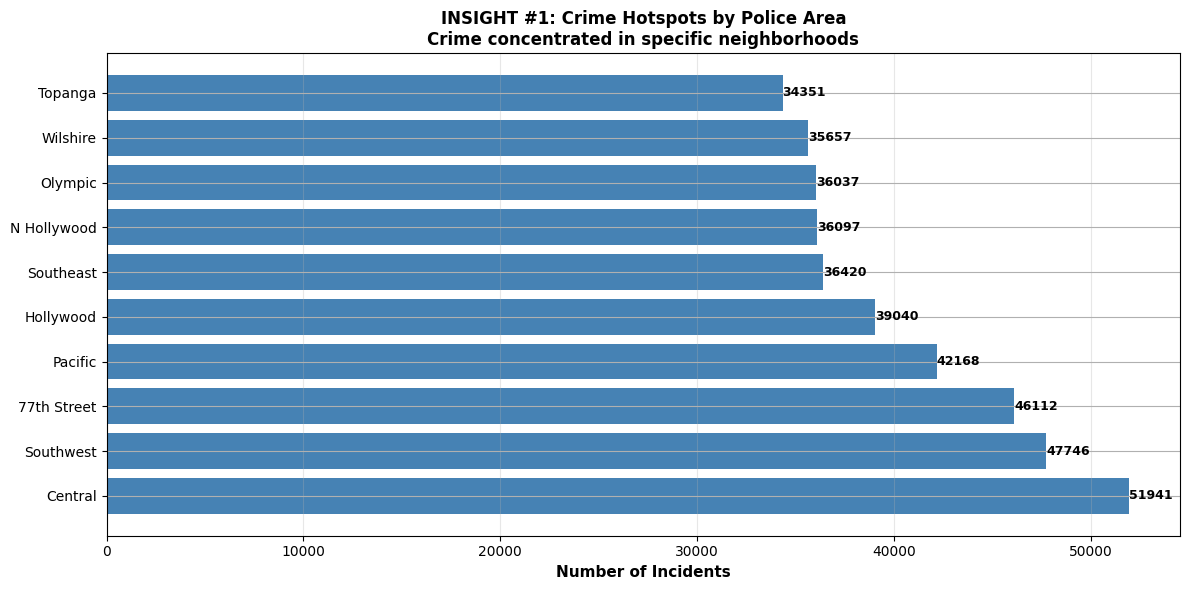

In [196]:
# Create visualization

plt.figure(figsize=(12, 6))
top_10 = area_counts.head(10)
bars = plt.barh(top_10['Area'], top_10['Total_Crimes'], color='steelblue')
plt.xlabel('Number of Incidents', fontsize=11, fontweight='bold')
plt.title('INSIGHT #1: Crime Hotspots by Police Area\nCrime concentrated in specific neighborhoods', 
          fontsize=12, fontweight='bold')
plt.grid(axis='x', alpha=0.3)

for bar in bars:
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height()/2, f'{int(width)}', 
             ha='left', va='center', fontsize=9, fontweight='bold')

plt.grid(True)
plt.tight_layout()
plt.show()


#### INSIGHT #2: VICTIM AGE BY CRIME TYPE


In [197]:
print("\nQ: Are certain age groups targeted for specific crimes?")


Q: Are certain age groups targeted for specific crimes?


In [198]:
top_crimes = df['crm_cd_desc'].value_counts().head().index


victim_age_by_crime = df[df['crm_cd_desc'].isin(top_crimes)].groupby('crm_cd_desc')['vict_age'].agg(['mean', 'median', 'count']).reset_index()
victim_age_by_crime.columns = ['Crime_Type', 'Mean_Age', 'Median_Age', 'Count']
victim_age_by_crime = victim_age_by_crime[victim_age_by_crime['Count'] > 10].sort_values('Mean_Age', ascending=False)

print("Victim Age by Crime Type:")
print(victim_age_by_crime.to_string(index=False))

oldest = victim_age_by_crime.iloc[0]
youngest = victim_age_by_crime.iloc[-1]
diff = oldest['Mean_Age'] - youngest['Mean_Age']
print(f"  Oldest victims: {oldest['Crime_Type']} (avg {oldest['Mean_Age']:.1f} years)")
print(f"  Youngest victims: {youngest['Crime_Type']} (avg {youngest['Mean_Age']:.1f} years)")
print(f"  Age difference: {diff:.1f} years")


Victim Age by Crime Type:
                                    Crime_Type  Mean_Age  Median_Age  Count
                             THEFT OF IDENTITY 41.692590        38.0  61322
                      BATTERY - SIMPLE ASSAULT 40.480122        38.0  73548
            THEFT PLAIN - PETTY ($950 & UNDER) 39.853422        36.0  46842
                         BURGLARY FROM VEHICLE 38.175408        35.0  61508
ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT 38.067214        36.0  51477
  Oldest victims: THEFT OF IDENTITY (avg 41.7 years)
  Youngest victims: ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT (avg 38.1 years)
  Age difference: 3.6 years


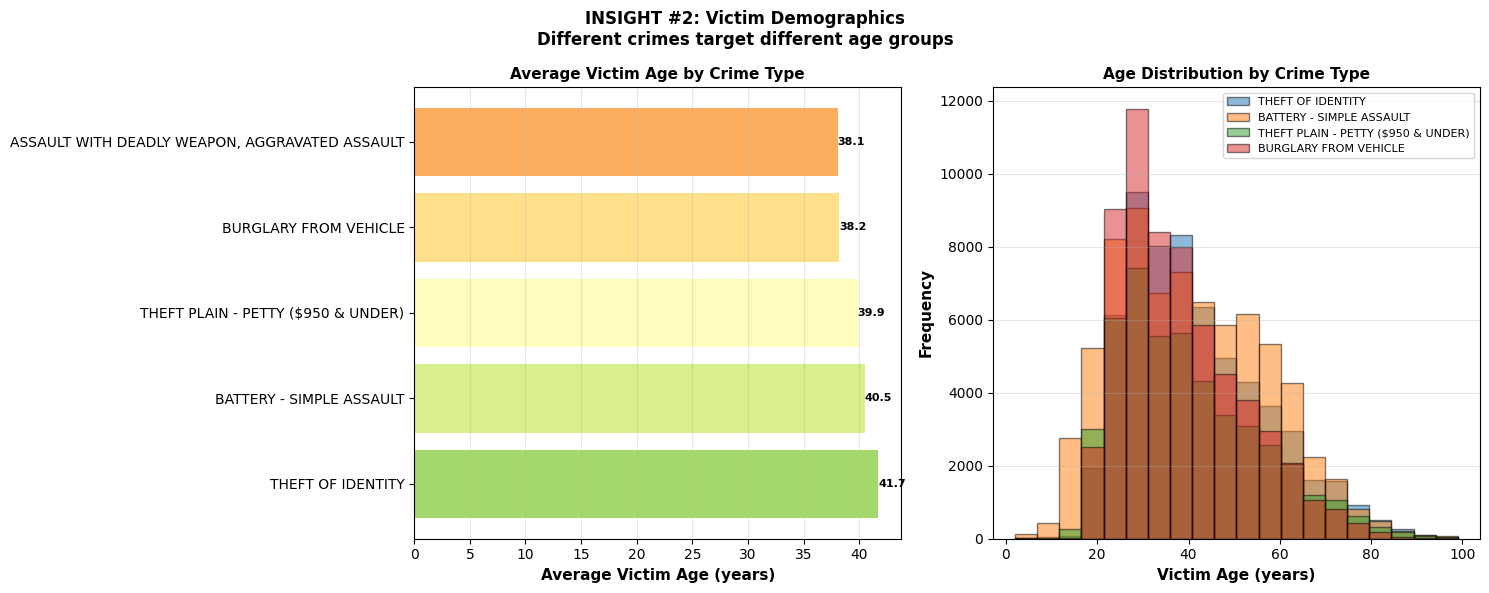

In [199]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Left: Average age by crime
colors = plt.cm.RdYlGn_r(np.linspace(0.3, 0.7, len(victim_age_by_crime)))
bars = ax1.barh(victim_age_by_crime['Crime_Type'], victim_age_by_crime['Mean_Age'], color=colors)
ax1.set_xlabel('Average Victim Age (years)', fontsize=11, fontweight='bold')
ax1.set_title('Average Victim Age by Crime Type', fontsize=11, fontweight='bold')
ax1.grid(axis='x', alpha=0.3)

for bar in bars:
    width = bar.get_width()
    ax1.text(width, bar.get_y() + bar.get_height()/2, f'{width:.1f}', 
             ha='left', va='center', fontsize=8, fontweight='bold')

# Right: Age distribution
for crime in victim_age_by_crime['Crime_Type'].head(4):
    crime_ages = df[df['crm_cd_desc'] == crime]['vict_age']
    ax2.hist(crime_ages[(crime_ages > 0) & (crime_ages <= 120)], bins=20, alpha=0.5, label=crime, edgecolor='black')

ax2.set_xlabel('Victim Age (years)', fontsize=11, fontweight='bold')
ax2.set_ylabel('Frequency', fontsize=11, fontweight='bold')
ax2.set_title('Age Distribution by Crime Type', fontsize=11, fontweight='bold')
ax2.legend(fontsize=8)
ax2.grid(axis='y', alpha=0.3)

fig.suptitle('INSIGHT #2: Victim Demographics\nDifferent crimes target different age groups', 
             fontsize=12, fontweight='bold')
plt.tight_layout()

#### INSIGHT 3: CRIME TYPE DISTRIBUTION BY AREA


In [200]:
print("\nQ: Do different areas experience different types of crimes?")



Q: Do different areas experience different types of crimes?


In [201]:
top_3_areas = df['area_name'].value_counts().head(3).index.tolist()


print("Top crime types in highest-crime areas:\n")
crime_by_area = []
for area in top_3_areas:
    area_crimes = df[df['area_name'] == area]['crm_cd_desc'].value_counts().head(5)
    print(f"{area}:")
    for crime, count in area_crimes.items():
        pct = (count / len(df[df['area_name'] == area])) * 100
        print(f"  - {crime}: {count} ({pct:.1f}%)")
    print()
    crime_by_area.append((area, area_crimes))


Top crime types in highest-crime areas:

Central:
  - BURGLARY FROM VEHICLE: 9463 (18.2%)
  - BATTERY - SIMPLE ASSAULT: 6649 (12.8%)
  - ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT: 3906 (7.5%)
  - THEFT PLAIN - PETTY ($950 & UNDER): 3834 (7.4%)
  - VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS): 3054 (5.9%)

Southwest:
  - BATTERY - SIMPLE ASSAULT: 4508 (9.4%)
  - THEFT OF IDENTITY: 3774 (7.9%)
  - ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT: 3594 (7.5%)
  - VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS): 3193 (6.7%)
  - THEFT PLAIN - PETTY ($950 & UNDER): 3060 (6.4%)

77th Street:
  - ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT: 5566 (12.1%)
  - BATTERY - SIMPLE ASSAULT: 4626 (10.0%)
  - THEFT OF IDENTITY: 4359 (9.5%)
  - INTIMATE PARTNER - SIMPLE ASSAULT: 3997 (8.7%)
  - ROBBERY: 3180 (6.9%)



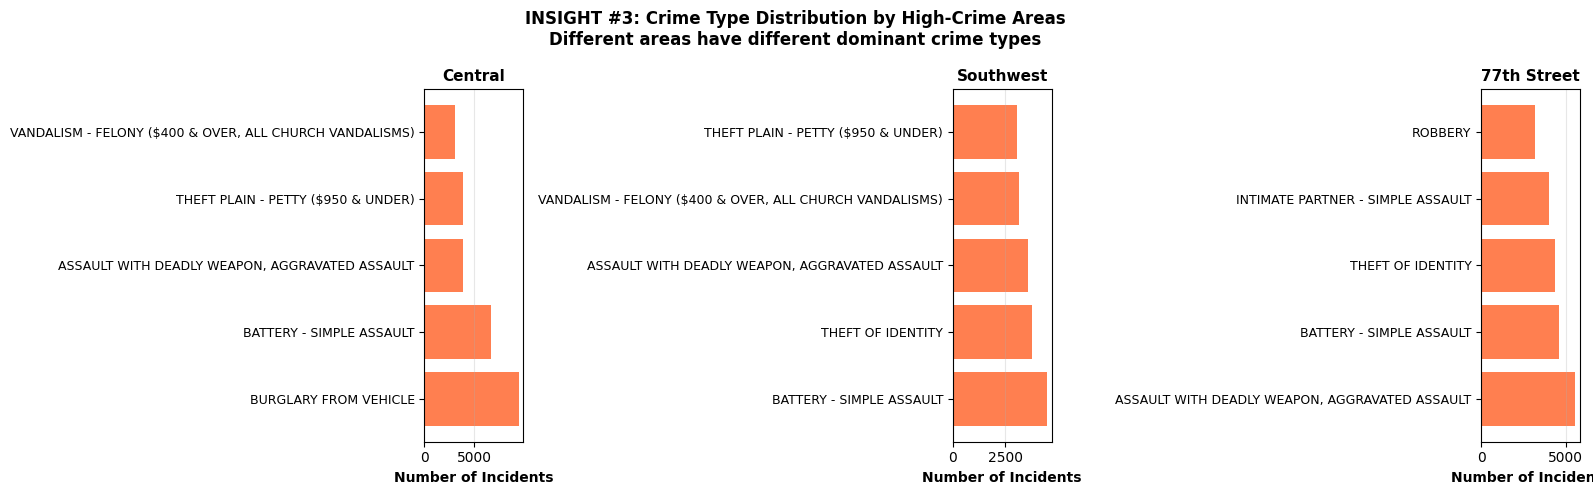

In [202]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

for idx, (area, crimes) in enumerate(crime_by_area):
    top_5 = crimes.head(5)
    axes[idx].barh(range(len(top_5)), top_5.values, color='coral')
    axes[idx].set_yticks(range(len(top_5)))
    axes[idx].set_yticklabels(top_5.index, fontsize=9)
    axes[idx].set_xlabel('Number of Incidents', fontsize=10, fontweight='bold')
    axes[idx].set_title(f'{area}', fontsize=11, fontweight='bold')
    axes[idx].grid(axis='x', alpha=0.3)

fig.suptitle('INSIGHT #3: Crime Type Distribution by High-Crime Areas\nDifferent areas have different dominant crime types', 
             fontsize=12, fontweight='bold')
plt.tight_layout()


### MODEL 1: CLUSTERING - IDENTIFYING CRIME HOTSPOT PATTERNS


In [203]:
# Prepare data for clustering
cluster_df = df.groupby('area_name').agg({
    'crm_cd_desc': 'count',  # Total crimes
    'vict_age': 'mean',  # Average victim age
    'LAT': 'mean',  # Center latitude
    'LON': 'mean'   # Center longitude
}).reset_index()

cluster_df.columns = ['Area', 'Crime_Count', 'Avg_Victim_Age', 'Latitude', 'Longitude']


In [204]:
# Normalize features for clustering
scaler = StandardScaler()
features_for_clustering = cluster_df[['Crime_Count', 'Avg_Victim_Age']].values
features_scaled = scaler.fit_transform(features_for_clustering)
silhouette_scores = []
for k in range(2, 6):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(features_scaled)
    score = silhouette_score(features_scaled, labels)
    silhouette_scores.append(score)
    print(f"  K={k}: Silhouette Score = {score:.3f}")
optimal_k = silhouette_scores.index(max(silhouette_scores)) + 2


  K=2: Silhouette Score = 0.428
  K=3: Silhouette Score = 0.384
  K=4: Silhouette Score = 0.371
  K=5: Silhouette Score = 0.457


In [205]:
# Apply K-Means with optimal k
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_df['Cluster'] = kmeans.fit_predict(features_scaled)

print(cluster_df[['Area', 'Crime_Count', 'Cluster']].to_string(index=False))

for i in range(optimal_k):
    cluster_data = cluster_df[cluster_df['Cluster'] == i]
    avg_crimes = cluster_data['Crime_Count'].mean()
    avg_age = cluster_data['Avg_Victim_Age'].mean()
    print(f"  Areas: {', '.join(cluster_data['Area'].tolist())}")
    print(f"  Avg crimes per area: {avg_crimes:.0f}")
    print(f"  Avg victim age: {avg_age:.1f} years")
    if avg_crimes > 30000:
        print(f"  Profile: HIGH-CRIME HOTSPOT")
    elif avg_crimes > 15000:
        print(f"  Profile: MEDIUM-CRIME AREA")
    else:
        print(f"  Profile: LOW-CRIME AREA")

       Area  Crime_Count  Cluster
77th Street        46112        1
    Central        51941        1
 Devonshire        29129        4
   Foothill        24497        0
     Harbor        27680        0
 Hollenbeck        24048        0
  Hollywood        39040        2
    Mission        30040        0
N Hollywood        36097        3
     Newton        33313        2
  Northeast        29360        0
    Olympic        36037        2
    Pacific        42168        3
    Rampart        32955        2
  Southeast        36420        2
  Southwest        47746        1
    Topanga        34351        3
   Van Nuys        33330        3
    West LA        33130        4
West Valley        30889        4
   Wilshire        35657        3
  Areas: Foothill, Harbor, Hollenbeck, Mission, Northeast
  Avg crimes per area: 27125
  Avg victim age: 40.1 years
  Profile: MEDIUM-CRIME AREA
  Areas: 77th Street, Central, Southwest
  Avg crimes per area: 48600
  Avg victim age: 37.4 years
  Profil

In [206]:
# Visualization 1: Clustering Results
plt.figure(figsize=(12, 7))
scatter = plt.scatter(cluster_df['Crime_Count'], cluster_df['Avg_Victim_Age'], 
                     c=cluster_df['Cluster'], cmap='viridis', s=300, alpha=0.7, edgecolors='black')

for idx, row in cluster_df.iterrows():
    plt.annotate(row['Area'][:3], 
                (row['Crime_Count'], row['Avg_Victim_Age']),
                fontsize=8, ha='center', va='center', fontweight='bold', color='white')

plt.xlabel('Total Crime Count', fontsize=12, fontweight='bold')
plt.ylabel('Average Victim Age (years)', fontsize=12, fontweight='bold')
plt.title('MODEL 1: Crime Area Clustering\nGrouping areas by crime volume and victim age profile', 
         fontsize=13, fontweight='bold')
plt.colorbar(scatter, label='Cluster')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('model1_clustering.png', dpi=300, bbox_inches='tight')
plt.close()
print(" Saved: model1_clustering.png")

 Saved: model1_clustering.png


### MODEL 2: REGRESSION - PREDICTING VICTIM AGE BY CRIME CHARACTERISTICS


In [207]:
print("MODEL 2: LINEAR REGRESSION - Victim Age Prediction")


MODEL 2: LINEAR REGRESSION - Victim Age Prediction


In [208]:
# Create features
crime_encoding = pd.factorize(df['crm_cd_desc'])[0]
area_encoding = pd.factorize(df['area_name'])[0]

X = pd.DataFrame({
    'Crime_Type': crime_encoding,
    'Area': area_encoding,
    'Hour': df['occ_hour'].fillna(0),
    'Month': df['occ_month'].fillna(0)
})
y = df['vict_age']

# Remove rows with missing target
valid_idx = y.notna()
X = X[valid_idx]
y = y[valid_idx]

# Train regression model
model = LinearRegression()
model.fit(X, y)
predictions = model.predict(X)
r2_score = model.score(X, y)

print(f"✓ Model trained")
print(f"  R² Score: {r2_score:.4f}")
print(f"\nFeature Importance (coefficients):")
features = ['Crime_Type', 'Area', 'Hour', 'Month']
for feature, coef in zip(features, model.coef_):
    print(f"  {feature}: {coef:.4f}")


✓ Model trained
  R² Score: 0.0059

Feature Importance (coefficients):
  Crime_Type: -0.0807
  Area: -0.0170
  Hour: -0.0372
  Month: -0.0079


In [209]:
plt.figure(figsize=(12, 6))

# Residuals plot
residuals = y - predictions
plt.subplot(1, 2, 1)
plt.scatter(predictions, residuals, alpha=0.3, s=10)
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
plt.xlabel('Predicted Victim Age', fontsize=11, fontweight='bold')
plt.ylabel('Residuals', fontsize=11, fontweight='bold')
plt.title('Residual Plot', fontsize=12, fontweight='bold')
plt.grid(True, alpha=0.3)

# Actual vs Predicted
plt.subplot(1, 2, 2)
plt.scatter(y, predictions, alpha=0.3, s=10)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
plt.xlabel('Actual Victim Age', fontsize=11, fontweight='bold')
plt.ylabel('Predicted Victim Age', fontsize=11, fontweight='bold')
plt.title(f'Actual vs Predicted (R² = {r2_score:.4f})', fontsize=12, fontweight='bold')
plt.grid(True, alpha=0.3)

plt.suptitle('MODEL 2: Linear Regression - Predicting Victim Age', 
            fontsize=13, fontweight='bold')
plt.tight_layout()

plt.savefig('model2_regression.png', dpi=300, bbox_inches='tight')
plt.close()
print("Saved: model2_regression.png")


Saved: model2_regression.png


#### MODEL 3: ANOMALY DETECTION - IDENTIFYING UNUSUAL CRIME PATTERNS


In [210]:
print("\nObjective: Find unusual/suspicious crime records")

print(df.columns.tolist())
time_num = pd.to_numeric(df['time_occ'], errors='coerce')
print(df[['time_occ','occ_hour']].head())



Objective: Find unusual/suspicious crime records
['DR_NO', 'date_reported', 'date_occ', 'time_occ', 'area', 'area_name', 'rpt_dist_no', 'part_1_2', 'crm_cd', 'crm_cd_desc', 'Mocodes', 'vict_age', 'vict_sex', 'vict_descent', 'premis_cd', 'premis_desc', 'weapon_used_cd', 'weapon_desc', 'Status', 'status_desc', 'Crm Cd 1', 'LOCATION', 'LAT', 'LON', 'occ_year', 'occ_month', 'occ_date', 'occ_day', 'occ_hour']
   time_occ  occ_hour
0  08:45:00         8
1  18:45:00        18
2  12:40:00        12
3  13:10:00        13
4  18:30:00        18


In [211]:

anomaly_df = df[['vict_age', 'occ_hour', 'occ_month']].copy()

# Force all to numeric
for c in anomaly_df.columns:
    anomaly_df[c] = pd.to_numeric(anomaly_df[c], errors='coerce')

# Fill missing with mean
anomaly_df = anomaly_df.fillna(anomaly_df.mean())

# Convert to float numpy array for scipy
z_scores = np.abs(stats.zscore(anomaly_df.astype(float).to_numpy(), nan_policy='omit'))

# Flag anomalies
anomalies = (z_scores > 2.5).any(axis=1)
num_anomalies = anomalies.sum()
anomaly_pct = (num_anomalies / len(df)) * 100

print(f"Anomalies detected: {num_anomalies} records ({anomaly_pct:.2f}%)")

Anomalies detected: 9523 records (1.30%)


In [212]:
normal = df[~anomalies]
anom = df[anomalies]

print(f"  Victim Age: {normal['vict_age'].mean():.1f} ± {normal['vict_age'].std():.1f} years")
print(f"  Avg Hour: {normal['occ_hour'].mean():.1f}")

print(f"\nAnomaly records:")
print(f"  Victim Age: {anom['vict_age'].mean():.1f} ± {anom['vict_age'].std():.1f} years")
print(f"  Avg Hour: {anom['occ_hour'].mean():.1f}")

  Victim Age: 38.9 ± 14.8 years
  Avg Hour: 13.1

Anomaly records:
  Victim Age: 84.6 ± 5.3 years
  Avg Hour: 12.8


In [213]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Age distribution
axes[0, 0].hist(normal['vict_age'], bins=30, alpha=0.7, label='Normal', edgecolor='black')
axes[0, 0].hist(anom['vict_age'], bins=30, alpha=0.7, label='Anomaly', edgecolor='black')
axes[0, 0].set_title('Age Distribution')
axes[0, 0].legend()

# Hour distribution
axes[0, 1].hist(normal['occ_hour'], bins=24, alpha=0.7, label='Normal', edgecolor='black')
axes[0, 1].hist(anom['occ_hour'], bins=24, alpha=0.7, label='Anomaly', edgecolor='black')
axes[0, 1].set_title('Time Distribution')
axes[0, 1].legend()

# Scatter
axes[1, 0].scatter(normal['occ_hour'], normal['vict_age'], alpha=0.3, s=10, label='Normal')
axes[1, 0].scatter(anom['occ_hour'], anom['vict_age'], alpha=0.7, s=30, label='Anomaly', marker='X')
axes[1, 0].set_title('Age vs Time Anomalies')
axes[1, 0].legend()

# Text summary (bottom-right)
axes[1, 1].axis('off')
axes[1, 1].text(0.02, 0.98, summary_text, va='top', family='monospace',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.suptitle('MODEL 3: Anomaly Detection - Unusual Crime Records')
plt.tight_layout()
plt.savefig('model3_anomaly_detection.png', dpi=300, bbox_inches='tight')
plt.close()
print(" Saved:model3_anomaly_detection.png")



 Saved:model3_anomaly_detection.png


In [214]:

# Summary statistics

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
summary_text = f"""
ANOMALY DETECTION RESULTS

Total Records: {len(df):,}
Normal Records: {len(normal):,} ({100-anomaly_pct:.2f}%)
Anomalous Records: {num_anomalies:,} ({anomaly_pct:.2f}%)

NORMAL PROFILE:
• Age: {normal['vict_age'].mean():.1f} ± {normal['vict_age'].std():.1f} years
• Hour: {normal['occ_hour'].mean():.1f} (peak activity)
• Month: {normal['occ_month'].mean():.1f}

ANOMALY PROFILE:
• Age: {anom['vict_age'].mean():.1f} ± {anom['vict_age'].std():.1f} years
• Hour: {anom['occ_hour'].mean():.1f}
• Month: {anom['occ_month'].mean():.1f}

KEY FINDING:
Anomalies represent unusual crime patterns
that warrant investigation or data review.
"""
axes[1, 1].text(0.1, 0.5, summary_text, fontsize=10, verticalalignment='center',
               family='monospace', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.suptitle('MODEL 3: Anomaly Detection - Unusual Crime Records', 
            fontsize=13, fontweight='bold')
plt.tight_layout()

plt.savefig('summary_model3_anomaly_detection.png', dpi=300, bbox_inches='tight')
plt.close()
print(" Saved: summary_model3_anomaly_detection.png")

 Saved: summary_model3_anomaly_detection.png
